# 1022 Project 2

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import scipy.stats as scs
import cvxpy as cp
import ipopt
import cplex
import statsmodels.api as smf

In [2]:
# Read Daily Prices
# CSV file with price data
input_file_prices  = 'monthly_adjusted_prices.csv'
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Read Market Cap
# CSV file with Market Cap
input_file_cap  = 'Market_Cap.csv'
# Read data into a dataframe
cap = pd.read_csv(input_file_cap)

In [3]:
if path.exists(input_file_prices):
    print('\nReading daily prices datafile - {}\n'.format(input_file_prices))
    fid = pd.read_csv(input_file_prices)
    # instrument tickers
    tickers = list(fid.columns)[1:]
    data_prices = fid.values[:,1:]
else:
    print("No such file '{}'".format(input_file_prices), file=sys.stderr)

# Number of assets in universe
Na = data_prices.shape[1]

# Number of historical scenarios
Ns = data_prices.shape[0]


Reading daily prices datafile - monthly_adjusted_prices.csv



In [4]:
n = 20
# Annual risk-free rate for years 2005-2008 is 4.3%
r_rf = (0.0429+0.048+0.0463+0.0366)/4
# Monthly risk-free rate
monthly_rf = r_rf / 12

# Compute means and covariances
cur_returns = data_prices[1:,:] / data_prices[:Ns-1,:] - 1
oct_returns = data_prices[-2,:] / data_prices[-3,:] -1   # Return in Oct. 2008
nov_returns = data_prices[-1,:] / data_prices[-2,:] -1   # Return in Nov. 2008
cur_returns = cur_returns[:-2,:]                         # Return from 30-Dec-2004 to 30-Sep-2008

# Expected returns from 30-Dec-2004 to 30-Sep-2008
mu = np.mean(cur_returns, axis=0).reshape(cur_returns.shape[1])
# Covariances for the return from 30-Dec-2004 to 30-Sep-2008
Q = np.cov(cur_returns.astype(float).T)

In [5]:
marketcap = np.array(cap["Cap"])
w_cap = marketcap / sum(marketcap)
ret_cap = np.dot(mu, w_cap)
var_cap = np.dot(w_cap, (np.dot(Q, w_cap)))

# Calculate Lambda based on Market Portfolio
lamda = (ret_cap - monthly_rf) / var_cap
lamda

3.878085491997312

## Sample Mean

In [6]:
mu

array([-0.014276068949839255, 0.008088460268996197, 0.00413065934160609,
       0.01795522880772803, 0.008146604003214541, 0.009273128230877625,
       0.005057420207739696, -0.011947795576973091, 0.0095175355871453,
       0.009691128964556997, 0.037063325230024154, 0.006492027423096824,
       -0.003225431250600419, 0.004406587645108931, 0.012579224294773374,
       0.02331904583647703, 0.004553230619698572, 0.007281333482620932,
       0.0008294256149203353, 0.0013058394606049134], dtype=object)

## Sample Variance

In [7]:
df_Q = pd.DataFrame(Q)
df_Q

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.014721,0.001548,0.001057,0.002166,7.086874e-04,-0.000391,1.724197e-03,0.004618,0.001966,0.003574,0.001562,0.002104,0.001282,0.000321,0.002238,0.000780,0.001087,0.001222,0.001768,-0.000203
1,0.001548,0.004283,0.000862,0.001250,4.969156e-04,-0.000104,-1.611960e-04,0.000337,-0.000827,-0.000236,0.003675,0.000983,0.001181,-0.000261,0.001743,0.002795,0.000097,0.001910,0.001639,0.001442
2,0.001057,0.000862,0.001953,0.000913,5.041601e-04,0.000338,1.726771e-04,0.000499,-0.000515,-0.000423,0.001410,0.000938,0.000169,0.000273,0.000244,0.000657,0.000264,0.000797,0.000725,-0.001018
3,0.002166,0.001250,0.000913,0.002626,1.013901e-03,0.000560,1.547019e-04,0.001143,0.000282,0.000909,0.004075,0.001398,0.000633,0.000538,0.001275,0.001455,0.000758,0.001092,0.001138,0.000067
4,0.000709,0.000497,0.000504,0.001014,1.234342e-03,0.000708,6.927599e-07,0.000575,0.000264,0.000730,0.001176,0.000475,0.000368,0.000519,0.000583,0.000352,0.000434,0.000777,0.000624,-0.000654
5,-0.000391,-0.000104,0.000338,0.000560,7.084092e-04,0.001304,-1.565350e-04,0.000575,0.000483,0.000724,0.000849,0.000035,0.000283,0.000677,-0.000149,-0.000256,0.000508,0.000373,0.000397,-0.001172
6,0.001724,-0.000161,0.000173,0.000155,6.927599e-07,-0.000157,1.959695e-03,0.000282,0.000560,0.000986,-0.000582,0.000463,-0.000710,0.000232,-0.000838,-0.001979,-0.000210,0.000028,0.000078,-0.001251
7,0.004618,0.000337,0.000499,0.001143,5.748997e-04,0.000575,2.816591e-04,0.006352,0.003721,0.004288,0.000854,0.000991,0.001176,0.000687,0.000538,-0.000697,0.000907,0.001081,0.001191,-0.001138
8,0.001966,-0.000827,-0.000515,0.000282,2.643581e-04,0.000483,5.599563e-04,0.003721,0.005304,0.004728,-0.002496,0.000556,0.001344,0.000434,-0.001066,-0.002649,0.000527,-0.000344,-0.000262,-0.001545
9,0.003574,-0.000236,-0.000423,0.000909,7.300467e-04,0.000724,9.855057e-04,0.004288,0.004728,0.005800,-0.000598,0.000676,0.001252,0.000640,-0.000544,-0.002404,0.000610,0.000524,0.000478,-0.001168


## Mean-Variance Optimization

\begin{equation}
  \begin{array}{lll}
    \displaystyle \max_{x} & \mu^Tx - \lambda x^TQx \\
    {\rm s.t.} & \begin{array}[t]{@{\hspace{0cm}}r@{\hspace{0.1cm}}c@{\hspace{0.1cm}}ll}        
          \sum_{i=1}^n x_i  = 1  \\
          \ -2 <= x_i <= 2  & \forall i\\
     \end{array}
  \end{array}
\end{equation}

In [8]:
x1 = cp.Variable(n)

prob1 = cp.Problem(cp.Maximize(mu.T @ x1 - lamda * cp.quad_form(x1, Q)),
                  [sum(x1) == 1, 
                   x1 >=-2, 
                   x1 <=2])
prob1.solve(solver=cp.CPLEX, verbose=True, cplex_params={"qpmethod": 6})

# Print results
print("\nSolution status: ", prob1.status)
print("Solution optimal value: ", prob1.value)
print("Solution w: ")
print(x1.value)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

### Mean-Variance Optimization

In [9]:
w_MVO = x1.value
retMVO = np.dot(mu, w_MVO)
varMVO = np.dot(w_MVO, (np.dot(Q, w_MVO)))
sdMVO = np.sqrt(varMVO)
sharpeMVO = (retMVO - monthly_rf) / sdMVO

### Oct. 2008 Mean-Variance Optimization

In [10]:
retMVO_oct = np.dot(oct_returns, w_MVO)
varMVO_oct = np.dot(w_MVO, (np.dot(Q, w_MVO)))
sdMVO_oct = np.sqrt(varMVO_oct)
sharpeMVO_oct = (retMVO_oct - monthly_rf) / sdMVO_oct

print("Mean-variance optimization portfolio in Oct. 2008:\n")
print("   Portfolio return =", retMVO_oct)
print(" Portfolio variance =", varMVO_oct)
print(" Standard deviation =", sdMVO_oct)
print("       Sharpe ratio =", sharpeMVO_oct)

Mean-variance optimization portfolio in Oct. 2008:

   Portfolio return = 0.18579977724338845
 Portfolio variance = 0.009905791419213284
 Standard deviation = 0.09952784243222237
       Sharpe ratio = 1.8304319621327816


### Nov. 2008 Mean-Variance Optimization

In [11]:
retMVO_nov = np.dot(nov_returns, w_MVO)
varMVO_nov = np.dot(w_MVO, np.dot(Q, w_MVO))
sdMVO_nov = np.sqrt(varMVO_nov)
sharpeMVO_nov = (retMVO_nov - monthly_rf) / sdMVO_nov

print("Mean-variance optimization portfolio in Nov. 2008:\n")
print("   Portfolio return =", retMVO_nov)
print(" Portfolio variance =", varMVO_nov)
print(" Standard deviation =", sdMVO_nov)
print("       Sharpe ratio =", sharpeMVO_nov)

Mean-variance optimization portfolio in Nov. 2008:

   Portfolio return = 0.2501459298725415
 Portfolio variance = 0.009905791419213284
 Standard deviation = 0.09952784243222237
       Sharpe ratio = 2.476946053634084


In [12]:
pd.options.display.float_format = '{:,.8f}'.format
data = {'Return':[retMVO, retMVO_oct, retMVO_nov],
       'Variance':[varMVO, varMVO_oct, varMVO_nov],
       'Standard deviation': [sdMVO, sdMVO_oct, sdMVO_nov],
       'Sharpe ratio': [sharpeMVO, sharpeMVO_oct, sharpeMVO_nov]}

result = pd.DataFrame(data, index = ['MVO','MVO in Oct','MVO in Nov'])
result

,Return,Variance,Standard deviation,Sharpe ratio
MVO,0.08102368,0.00990579,0.09952784,0.77770042
MVO in Oct,0.18579978,0.00990579,0.09952784,1.83043196
MVO in Nov,0.25014593,0.00990579,0.09952784,2.47694605


## Robust Mean-Variance Optimization

\begin{equation}
  \begin{array}{lll}
    \displaystyle \max_{x} & \mu^Tx - \lambda x^TQx \\
    {\rm s.t.} & \begin{array}[t]{@{\hspace{0cm}}r@{\hspace{0.1cm}}c@{\hspace{0.1cm}}ll}        
          \mu^T x - \delta^T |x| & \geq & R \\
          \sum_{i=1}^n x_i & = & 1  \\
          \ -2 <= x_i <= 2 & \forall i\\
     \end{array}
  \end{array}
\end{equation}

In [13]:
# Theta
theta = (np.sqrt(np.diag(np.diag(Q))))/(np.sqrt(Ns-3))

# 90% confidence interval
delta_90 = 1.645*theta

# 95% confidence interval
delta_95 = 1.96*theta

In [14]:
# Target portfolio return is return of MVO portfolio
Portf_Retn_90 = cp.Parameter()
Portf_Retn_90.value = retMVO

x2 = cp.Variable(n)
y = cp.abs(x2)
prob2 = cp.Problem(cp.Maximize(mu.T @ x2 - lamda * cp.quad_form(x2, Q)),
                  [mu.T@x2 - delta_90.T@y >= Portf_Retn_90,
                   sum(x2) == 1,
                   x2 >= -2,
                   x2 <= 2])
prob2.solve(solver=cp.CPLEX, verbose=True)

# Print results
print("\nSolution status: ", prob2.status)
print("Solution optimal value: ", prob2.value)
print("Solution w: ")
print(x2.value)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space

In [15]:
# Target portfolio return is return of MVO portfolio
Portf_Retn_95 = cp.Parameter()
Portf_Retn_95.value = retMVO

x3 = cp.Variable(n)
y = cp.abs(x3)
prob3 = cp.Problem(cp.Maximize(mu.T @ x2 - lamda * cp.quad_form(x2, Q)),
                  [mu.T@x3 - delta_95.T@y >= Portf_Retn_95,
                   sum(x3) == 1])
prob3.solve(solver=cp.CPLEX, verbose=True)

# Print results
print("\nSolution status: ", prob3.status)
print("Solution optimal value: ", prob3.value)
print("Solution w: ")
print(x3.value)

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 20 rows and 40 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 61 rows, 40 columns, and 520 nonzeros.
Presolve time = 0.00 sec. (0.08 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1070
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.05 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 61
  Integer space required    = 334
  Total non-zeros in factor

### Robust Mean-Variance Optimization

In [16]:
w_RMVO1 = x2.value
retRMVO1 = np.dot(mu, w_RMVO1)
varRMVO1 = np.dot(w_RMVO1, (np.dot(Q, w_RMVO1)))
sdRMVO1 = np.sqrt(varRMVO1)
sharpeRMVO1 = (retRMVO1 - monthly_rf) / sdRMVO1

w_RMVO2 = x3.value
retRMVO2 = np.dot(mu, w_RMVO2)
varRMVO2 = np.dot(w_RMVO2, (np.dot(Q, w_RMVO2)))
sdRMVO2 = np.sqrt(varRMVO2)
sharpeRMVO2 = (retRMVO2 - monthly_rf) / sdRMVO2

### Oct. 2008 Robust Mean-Variance Optimization at 90% Confidence Interval

In [17]:
w_RMVO = x2.value
retRMVO_oct1 = np.dot(oct_returns, w_RMVO)
varRMVO_oct1 = np.dot(w_RMVO, (np.dot(Q, w_RMVO)))
sdRMVO_oct1 = np.sqrt(varRMVO_oct1)
sharpeRMVO_oct1 = (retRMVO_oct1 - monthly_rf) / sdRMVO_oct1

print("Robust Mean-variance optimization portfolio in Oct. 2008:\n")
print("   Portfolio return =", retRMVO_oct1)
print(" Portfolio variance =", varRMVO_oct1)
print(" Standard deviation =", sdRMVO_oct1)
print("       Sharpe ratio =", sharpeRMVO_oct1)

Robust Mean-variance optimization portfolio in Oct. 2008:

   Portfolio return = -0.20130021755935804
 Portfolio variance = 0.012592329879073914
 Standard deviation = 0.1122155509680985
       Sharpe ratio = -1.826137724449153


### Nov. 2008 Robust Mean-Variance Optimization at 90% Confidence Interval

In [18]:
retRMVO_nov1 = np.dot(nov_returns, w_RMVO)
varRMVO_nov1 = np.dot(w_RMVO, (np.dot(Q, w_RMVO)))
sdRMVO_nov1 = np.sqrt(varRMVO_nov1)
sharpeRMVO_nov1 = (retRMVO_nov1 - monthly_rf) / sdRMVO_nov1

print("Robust Mean-variance optimization portfolio in Nov. 2008:\n")
print("   Portfolio return =", retRMVO_nov1)
print(" Portfolio variance =", varRMVO_nov1)
print(" Standard deviation =", sdRMVO_nov1)
print("       Sharpe ratio =", sharpeRMVO_nov1)

Robust Mean-variance optimization portfolio in Nov. 2008:

   Portfolio return = 0.35766454244273416
 Portfolio variance = 0.012592329879073914
 Standard deviation = 0.1122155509680985
       Sharpe ratio = 3.1550324893031187


### Oct. 2008 Robust Mean-Variance Optimization at 95% Confidence Interval

In [19]:
w_RMVO = x3.value
retRMVO_oct2 = np.dot(oct_returns, w_RMVO)
varRMVO_oct2 = np.dot(w_RMVO, (np.dot(Q, w_RMVO)))
sdRMVO_oct2 = np.sqrt(varRMVO_oct2)
sharpeRMVO_oct2 = (retRMVO_oct2 - monthly_rf) / sdRMVO_oct2

print("Robust Mean-variance optimization portfolio in Oct. 2008:\n")
print("   Portfolio return =", retRMVO_oct2)
print(" Portfolio variance =", varRMVO_oct2)
print(" Standard deviation =", sdRMVO_oct2)
print("       Sharpe ratio =", sharpeRMVO_oct2)

Robust Mean-variance optimization portfolio in Oct. 2008:

   Portfolio return = 0.12937691329610806
 Portfolio variance = 0.04762099515936972
 Standard deviation = 0.21822235256583986
       Sharpe ratio = 0.5762749713040184


### Nov. 2008 Robust Mean-Variance Optimization at 95% Confidence Interval

In [20]:
retRMVO_nov2 = np.dot(nov_returns, w_RMVO)
varRMVO_nov2 = np.dot(w_RMVO, (np.dot(Q, w_RMVO)))
sdRMVO_nov2 = np.sqrt(varRMVO_nov2)
sharpeRMVO_nov2 = (retRMVO_nov2 - monthly_rf) / sdRMVO_nov2

print("Robust Mean-variance optimization portfolio in Nov. 2008:\n")
print("   Portfolio return =", retRMVO_nov2)
print(" Portfolio variance =", varRMVO_nov2)
print(" Standard deviation =", sdRMVO_nov2)
print("       Sharpe ratio =", sharpeRMVO_nov2)

Robust Mean-variance optimization portfolio in Nov. 2008:

   Portfolio return = 0.2544036927219817
 Portfolio variance = 0.04762099515936972
 Standard deviation = 0.21822235256583986
       Sharpe ratio = 1.1492079360338885


In [21]:
pd.options.display.float_format = '{:,.8f}'.format
data = {'Return':[retRMVO1, retRMVO2, retRMVO_oct1, retRMVO_oct2, retRMVO_nov1, retRMVO_nov2],
       'Variance':[varRMVO1, varRMVO2, varRMVO_oct1, varRMVO_oct2, varRMVO_nov1, varRMVO_nov2],
       'Standard deviation': [sdRMVO1, sdRMVO2, sdRMVO_oct1, sdRMVO_oct2, sdRMVO_nov1, sdRMVO_nov2],
       'Sharpe ratio': [sharpeRMVO1, sharpeRMVO2, sharpeRMVO_oct1, sharpeRMVO_oct2, sharpeRMVO_nov1, sharpeRMVO_nov2]}

result = pd.DataFrame(data, index = ['Robust MVO 90%','Robust MVO 95%','Robust MVO in Oct 90%',\
                                     'Robust MVO in Oct 95%','Robust MVO in Nov 90%','Robust MVO in Nov 95%'])
result

,Return,Variance,Standard deviation,Sharpe ratio
Robust MVO 90%,0.09766826,0.01259233,0.11221555,0.83809623
Robust MVO 95%,0.11818736,0.04762100,0.21822235,0.52499906
Robust MVO in Oct 90%,-0.20130022,0.01259233,0.11221555,-1.82613772
Robust MVO in Oct 95%,0.12937691,0.04762100,0.21822235,0.57627497
Robust MVO in Nov 90%,0.35766454,0.01259233,0.11221555,3.15503249
Robust MVO in Nov 95%,0.25440369,0.04762100,0.21822235,1.14920794


In [22]:
nov_returns

array([0.22831014048217346, 0.07303678452001372, -0.13083775126701935,
       0.023160384185372473, 0.0728218709174584, -0.005437585002836531,
       0.0012538822062464483, -0.39267404052433663, -0.1432451203903783,
       -0.23248493870154818, -0.1386743509119338, -0.11739071084984709,
       -0.055864620728440784, -0.037058045652788474, 0.08757274659105185,
       -0.09218061495839103, -0.054538868562967746, 0.06686587162490687,
       0.1004381259026661, 0.27752493204167217], dtype=object)

## Risk Parity optimization with no short selling

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{x} & \displaystyle \sum_{i=1}^n \sum_{j=1}^n \left( x_i (Qx)_i - x_j (Qx)_j \right)^2 \\
  \mbox{s.t.} & \sum_{i=1}^n x_i = 1 \\
  & x \geq 0
 \end{array}
\end{equation}

In [23]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(20):
            for j in range(i,20):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(20)
        
        y = x * np.dot(Q,x)

        for i in range(20):
            for j in range(i,20):
            # fill the code
                a = Q[i].dot(x) + Q[i,i] * x[i]
                b = Q[i,j] * x[i]
                delta_g = (y[i]-y[j]) * (a - b)
                grad[i] = grad[i] + delta_g

            grad[i] = 2 * 2 * grad[i]
        
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * 20
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * 20])


n = 20          # 20 assets
# Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization
w0 = [1.0/n] * n
lb = [0.0] * n  # lower bounds on variables
ub = [1.0] * n  # upper bounds on variables
cl = [1]        # lower bounds on constraints
cu = [1]        # upper bounds on constraints
# Define IPOPT problem
nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
# Set the IPOPT options
nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
nlp.addOption('tol'.encode('utf-8'), 1e-10)
# Solve the problem
w_erc, info = nlp.solve(w0)

### Risk Parity Optimization

In [24]:
w_ERC = w_erc / np.sum(w_erc)
retERC = np.dot(mu, w_ERC)
varERC = np.dot(w_ERC, (np.dot(Q, w_ERC)))
sdERC = np.sqrt(varERC)
sharpeERC = (retERC - monthly_rf) / sdERC

### Oct. 2008 Risk Parity optimization

In [25]:
w_ERC = w_erc / np.sum(w_erc)
retERC_oct = np.dot(oct_returns, w_ERC)
varERC_oct = np.dot(w_ERC, (np.dot(Q, w_ERC)))
sdERC_oct = np.sqrt(varERC_oct)
sharpeERC_oct = (retERC_oct - monthly_rf) / sdERC_oct

print("Risk Parity optimization portfolio in Oct. 2008:\n")
print("   Portfolio return =", retERC_oct)
print(" Portfolio variance =", varERC_oct)
print(" Standard deviation =", sdERC_oct)
print("       Sharpe ratio =", sharpeERC_oct)

Risk Parity optimization portfolio in Oct. 2008:

   Portfolio return = -0.14619216323990392
 Portfolio variance = 0.00047175334385839444
 Standard deviation = 0.021719883606004763
       Sharpe ratio = -6.8975045764895055


### Nov. 2008 Risk Parity optimization

In [26]:
retERC_nov = np.dot(nov_returns, w_ERC)
varERC_nov = np.dot(w_ERC, (np.dot(Q, w_ERC)))
sdERC_nov = np.sqrt(varERC_nov)
sharpeERC_nov = (retERC_nov - monthly_rf) / sdERC_nov

print("Risk Parity optimization portfolio in Nov. 2008:\n")
print("   Portfolio return =", retERC_nov)
print(" Portfolio variance =", varERC_nov)
print(" Standard deviation =", sdERC_nov)
print("       Sharpe ratio =", sharpeERC_nov)

Risk Parity optimization portfolio in Nov. 2008:

   Portfolio return = -0.008567638596590335
 Portfolio variance = 0.00047175334385839444
 Standard deviation = 0.021719883606004763
       Sharpe ratio = -0.5611665398867053


In [27]:
pd.options.display.float_format = '{:,.8f}'.format
data = {'Return':[retERC, retERC_oct, retERC_nov],
       'Variance':[varERC, varERC_oct, varERC_nov],
       'Standard deviation': [sdERC, sdERC_oct, sdERC_nov],
       'Sharpe ratio': [sharpeERC, sharpeERC_oct, sharpeERC_nov]}

result = pd.DataFrame(data, index = ['ERC','ERC in Oct','ERC in Nov'])
result

,Return,Variance,Standard deviation,Sharpe ratio
ERC,0.00627249,0.00047175,0.02171988,0.12208440
ERC in Oct,-0.14619216,0.00047175,0.02171988,-6.89750458
ERC in Nov,-0.00856764,0.00047175,0.02171988,-0.56116654


## Market Cap Portfolio

In [28]:
w_cap

array([0.00516568, 0.01600871, 0.02350937, 0.02479654, 0.04832846,
       0.04331171, 0.08484139, 0.07692692, 0.04500183, 0.06065971,
       0.04082653, 0.05716926, 0.06693682, 0.07714606, 0.18018094,
       0.01244933, 0.005071  , 0.07840855, 0.04445846, 0.00880272])

In [29]:
retcap = np.dot(mu, w_cap)
varcap = np.dot(w_cap, (np.dot(Q, w_cap)))
sdcap = np.sqrt(varcap)
sharpecap = (retcap - monthly_rf) / sdcap

### Oct. 2008 Market Cap Portfolio

In [30]:
retcap_oct = np.dot(oct_returns, w_cap)
varcap_oct = np.dot(w_cap, (np.dot(Q, w_cap)))
sdcap_oct = np.sqrt(varcap_oct)
sharpecap_oct = (retcap_oct - monthly_rf) / sdcap_oct

print("Market Cap portfolio in Oct. 2008:\n")
print("   Portfolio return =", retcap_oct)
print(" Portfolio variance =", varcap_oct)
print(" Standard deviation =", sdcap_oct)
print("       Sharpe ratio =", sharpecap_oct)

Market Cap portfolio in Oct. 2008:

   Portfolio return = -0.11672674980587304
 Portfolio variance = 0.0009041352101523507
 Standard deviation = 0.03006884118406213
       Sharpe ratio = -4.00240176874512


### Nov. 2008 Market Cap Portfolio

In [31]:
retcap_nov = np.dot(nov_returns, w_cap)
varcap_nov = np.dot(w_cap, (np.dot(Q, w_cap)))
sdcap_nov = np.sqrt(varcap_nov)
sharpecap_nov = (retcap_nov - monthly_rf) / sdcap_nov

print("Market Cap portfolio in Nov. 2008:\n")
print("   Portfolio return =", retcap_nov)
print(" Portfolio variance =", varcap_nov)
print(" Standard deviation =", sdcap_nov)
print("       Sharpe ratio =", sharpecap_nov)

Market Cap portfolio in Nov. 2008:

   Portfolio return = -0.03998381877119876
 Portfolio variance = 0.0009041352101523507
 Standard deviation = 0.03006884118406213
       Sharpe ratio = -1.450160710803999


In [32]:
pd.options.display.float_format = '{:,.8f}'.format
data = {'Return':[retcap, retcap_oct, retcap_nov],
       'Variance':[varcap, varcap_oct, varcap_nov],
       'Standard deviation': [sdcap, sdcap_oct, sdcap_nov],
       'Sharpe ratio': [sharpecap, sharpecap_oct, sharpecap_nov]}

result = pd.DataFrame(data, index = ['Market','Market in Oct','Market in Nov'])
result

,Return,Variance,Standard deviation,Sharpe ratio
Market,0.00712715,0.00090414,0.03006884,0.11660954
Market in Oct,-0.11672675,0.00090414,0.03006884,-4.00240177
Market in Nov,-0.03998382,0.00090414,0.03006884,-1.45016071


## Question (a)

In [33]:
pd.options.display.float_format = '{:,.8f}'.format
data = {'Return':[retMVO_oct, retRMVO_oct1, retRMVO_oct2, retERC_oct, retcap_oct],
       'Variance':[varMVO_oct, varRMVO_oct1, varRMVO_oct2, varERC_oct, varcap_oct],
       'Standard deviation': [sdMVO_oct, sdRMVO_oct1, sdRMVO_oct2, sdERC_oct, sdcap_oct],
       'Sharpe ratio': [sharpeMVO_oct, sharpeRMVO_oct1, sharpeRMVO_oct2, sharpeERC_oct, sharpecap_oct]}

result = pd.DataFrame(data, index = ['MVO','Robust MVO 90%','Robust MVO 95%','ERC','Market Cap'])
result

,Return,Variance,Standard deviation,Sharpe ratio
MVO,0.18579978,0.00990579,0.09952784,1.83043196
Robust MVO 90%,-0.20130022,0.01259233,0.11221555,-1.82613772
Robust MVO 95%,0.12937691,0.04762100,0.21822235,0.57627497
ERC,-0.14619216,0.00047175,0.02171988,-6.89750458
Market Cap,-0.11672675,0.00090414,0.03006884,-4.00240177


## Question (b)

In [34]:
pd.options.display.float_format = '{:,.8f}'.format
data = {'Return':[retMVO_nov, retRMVO_nov1, retRMVO_nov2, retERC_nov, retcap_nov],
       'Variance':[varMVO_nov, varRMVO_nov1, varRMVO_nov2, varERC_nov, varcap_nov],
       'Standard deviation': [sdMVO_nov, sdRMVO_nov1, sdRMVO_nov2, sdERC_nov, sdcap_nov],
       'Sharpe ratio': [sharpeMVO_nov, sharpeRMVO_nov1, sharpeRMVO_nov2, sharpeERC_nov, sharpecap_nov]}

result = pd.DataFrame(data, index = ['MVO','Robust MVO 90%','Robust MVO 95%','ERC','Market Cap'])
result

,Return,Variance,Standard deviation,Sharpe ratio
MVO,0.25014593,0.00990579,0.09952784,2.47694605
Robust MVO 90%,0.35766454,0.01259233,0.11221555,3.15503249
Robust MVO 95%,0.25440369,0.04762100,0.21822235,1.14920794
ERC,-0.00856764,0.00047175,0.02171988,-0.56116654
Market Cap,-0.03998382,0.00090414,0.03006884,-1.45016071


## Question (c)

In [35]:
targetRet = np.linspace(0.1, 20,100)
w_eef_list = []
var_eef_list = []
ret_eef_list = []
for ld in targetRet: 
    x_eef = cp.Variable(n)
    prob_eef = cp.Problem(cp.Maximize(mu.T @ x_eef - ld * cp.quad_form(x_eef, Q)),
                  [sum(x_eef) == 1,
                  x_eef >= -2,
                  x_eef <=2 ])
    prob_eef.solve(solver=cp.CPLEX, verbose=True, cplex_params={"qpmethod": 6})
    w_eef_list.append(x_eef.value)
    var_eef_list.append(np.dot(x_eef.value, np.dot(Q, x_eef.value)))
    ret_eef_list.append(np.dot(mu, x_eef.value))

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Reduced QP has 1 rows, 20 columns, and 20 nonzeros.
Reduced QP objective Q matrix has 400 nonzeros.
Presolve time = 0.05 sec. (0.06 ticks)

Iteration log . . .
Iteration:     1    Phase I obj   =             4.403606

Dual simplex solved model.

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck              

Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Reduced QP has 1 rows, 20 columns, and 20 nonzeros.
Reduced QP objective Q matrix has 400 nonzeros.
Presolve time = 0.05 sec. (0.06 ticks)

Iteration log . . .
Iteration:     1    Phase I obj   =             4.734051

Dual simplex solved model.

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degre

Reduced QP objective Q matrix has 400 nonzeros.
Presolve time = 0.03 sec. (0.06 ticks)

Iteration log . . .
Iteration:     1    Phase I obj   =             5.064497

Dual simplex solved model.

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approx

In [36]:
targetRet = np.linspace(0.1, 30,100)
w_tef_list = []
var_tef_list = []
ret_tef_list = []
for ld in targetRet: 
    x_tef = cp.Variable(n)
#     prob_tef = cp.Problem(cp.Maximize(realized_retMVO_oct.T @ x_tef - ld * cp.quad_form(x_tef, Q)),
#                   [sum(x_tef) == 1,
#                   x_tef >= -2,
#                   x_tef <=2 ])
    prob_tef = cp.Problem(cp.Maximize(oct_returns.T @ x_tef - ld * cp.quad_form(x_tef, Q)),
                  [sum(x_tef) == 1,
                  x_tef >= -2,
                  x_tef <=2 ])
    prob_tef.solve(solver=cp.CPLEX, verbose=True, cplex_params={"qpmethod": 6})
    w_tef_list.append(x_tef.value)
    var_tef_list.append(np.dot(x_tef.value, np.dot(Q, x_tef.value)))
#     ret_tef_list.append(np.dot(realized_retMVO_oct, x_tef.value))
    ret_tef_list.append(np.dot(oct_returns, x_tef.value))

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to facto

In [37]:
w_aef_list = w_eef_list
var_aef_list = []
ret_aef_list = []
for i in range(len(w_aef_list)):
    var_aef_list.append(np.dot(w_aef_list[i], np.dot(Q, w_aef_list[i])))
#     ret_aef_list.append(np.dot(realized_retMVO_oct, w_aef_list[i]))
    ret_aef_list.append(np.dot(oct_returns, w_aef_list[i]))

In [38]:
targetRet = np.linspace(0.1,10,100)
w_eref90_list = []
var_eref90_list = []
ret_eref90_list = []
for ld in targetRet:
    
    Portf_Retn_90 = cp.Parameter()
    Portf_Retn_90.value = retMVO
    x_eref90 = cp.Variable(n)
    y = cp.abs(x_eref90)
    prob_eref90 = cp.Problem(cp.Maximize(mu.T @ x_eref90 - ld * cp.quad_form(x_eref90, Q)),
                  [mu.T@x_eref90 - delta_90.T@y >= Portf_Retn_90,
                   sum(x_eref90) == 1,
                   x_eref90 >= -2,
                   x_eref90 <= 2])
    prob_eref90.solve(solver=cp.CPLEX, verbose=True)
    w_eref90_list.append(x_eref90.value)
    var_eref90_list.append(np.dot(x_eref90.value, np.dot(Q, x_eref90.value)))
    ret_eref90_list.append(np.dot(mu, x_eref90.value))

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space

   4  -8.9081122e-02  -1.1071726e+00  2.42e-04  2.89e-15  2.50e-01
   5  -9.1975767e-02  -3.6463823e-01  6.58e-05  1.67e-15  7.15e-02
   6  -9.9146294e-02  -1.2352285e-01  1.04e-05  1.67e-15  1.58e-02
   7  -1.2576540e-01  -1.1778075e-01  7.39e-06  1.11e-15  1.17e-02
   8  -1.8144336e-01  -1.3895719e-01  5.07e-06  2.28e-15  8.39e-03
   9  -1.9657865e-01  -1.7177611e-01  2.42e-06  1.62e-15  4.08e-03
  10  -1.9981927e-01  -1.9749689e-01  4.54e-07  2.20e-15  7.73e-04
  11  -2.0192844e-01  -2.0202903e-01  1.50e-09  2.20e-15  4.07e-06
  12  -2.0196987e-01  -2.0197229e-01  5.89e-12  2.31e-15  2.05e-08
  13  -2.0197039e-01  -2.0197043e-01  5.66e-13  1.01e-15  4.09e-11
  14  -2.0197040e-01  -2.0197040e-01  7.83e-13  9.98e-16  7.53e-17
Barrier time = 0.01 sec. (0.98 ticks)

Total time on 8 threads = 0.01 sec. (0.98 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Mini

Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  -5.3263143e-02  -8.0000426e+04  4.08e+01  0.00e+00  4.00e+04
   1  -5.9028761e-02  -2.6638714e+04  1.40e+01  1.11e-15  1.37e+04
   2  -7.3920878e-02  -3.8705162e+03  1.30e+00  4.44e-16  1.27e+03
   3  -7.5315146e-02  -2.9724629e+01  9.48e-03  1.78e-15  9.30e+00
   4  -7.6124619e-02  -1.0608571e+00  2.28e-04  1.67e-15  2.36e-01
   5  -8.1723412e-02  -4.2773023e-01  8.09e-05  1.11e-15  8.73e-02
   6  -8.8936442e-02  -1.3288284e-01  1.34e-05  4.44e-16  1.85e-02
   7  -1.0115699e-01  -1.1391660e-01  7.67e-06  2.00e-15  1.14e-02
   8  -1.2973166e-01  -1

CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271


   8  -8.7551192e-02  -9.2170507e-02  3.53e-06  2.50e-15  5.04e-03
   9  -9.3826733e-02  -9.3575455e-02  8.65e-07  2.80e-15  1.38e-03
  10  -9.4443669e-02  -9.4511914e-02  2.45e-08  2.23e-15  4.74e-05
  11  -9.4462101e-02  -9.4466610e-02  2.72e-11  2.24e-15  7.21e-08
  12  -9.4462419e-02  -9.4462480e-02  4.65e-13  1.65e-15  7.68e-13
  13  -9.4462422e-02  -9.4462422e-02  5.65e-13  2.11e-15  2.40e-16
Barrier time = 0.03 sec. (0.93 ticks)

Total time on 8 threads = 0.03 sec. (0.93 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve ad

 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  -1.6121732e-02  -8.0000463e+04  4.08e+01  0.00e+00  4.00e+04
   1  -1.5664365e-02  -2.6615951e+04  1.40e+01  0.00e+00  1.37e+04
   2  -3.6649432e-02  -3.8635412e+03  1.29e+00  1.11e-15  1.27e+03
   3  -3.8642499e-02  -2.9545607e+01  9.43e-03  1.67e-15  9.25e+00
   4  -4.2359065e-02  -1.3865430e+00  3.37e-04  1.89e-15  3.41e-01
   5  -5.5878540e-02  -4.9267742e-01  1.09e-04  2.22e-16  1.14e-01
   6  -6.5771393e-02  -1.2951893e-01  1.73e-05  1.44e-15  2.11e-02
   7  -7.2496219e-02  -8.9965841e-02  6.03e-06  1.78e-15  7.87e-03
   8  -7.6394066e-02  -8.1963313e-02  2.58e-06  1.11e-15  3.51e-03
   9  -7.8825782e-02  -7.9734844e-02  7.07e-07  1.50e-15  1.04e-03
  10  -7.9164415e-02  -7.9246167e-02  7.85e-09  2.01e-15  1.71e-05
  11  -7.9174106e-02  -7.9179197e-02  2.95e-11  1.53e-15  7.52e-08
  12  -7.9174635e-02  -7.9174935e-02  2.71e-11  2.34e-15  3.12e-10
  13  -7.9174646e-02  -7.9174653e-02  2.98e-10  1.50

Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  -2.8038536e-03  -8.0000476e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.3556449e-05  -2.6606675e+04  1.40e+01  2.22e-15  1.37e+04
   2  -2.3127605e-02  -3.8607955e+03  1.29e+00  1.44e-15  1.27e+03
   3  -2.5339633e-02  -2.9471350e+01  9.41e-03  1.11e-15  9.23e+00
   4  -3.0637248e-02  -1.4953467e+00  3.74e-04  1.33e-15  3.76e-01
   5  -4.7280231e-02  -4.8160626e-01  1.10e-04  2.00e-15  1.14e-01
   6  -5.8122137e-02  -1.2536141e-01  1.79e-05  1.55e-15  2.12e-02
   7  -6.3958011e-02  -8.2014965e-02  5.6

  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.0416323e-02  -8.0000489e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.5643770e-02  -2.6597937e+04  1.40e+01  6.66e-16  1.37e+04
   2  -9.6201199e-03  -3.8582313e+03  1.29e+00  4.44e-16  1.27e+03
   3  -1.2053926e-02  

CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271


Barrier time = 0.03 sec. (0.84 ticks)

Total time on 8 threads = 0.03 sec. (0.84 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.02 sec. (0.12 ticks)
Summary statistics for Cholesky 

Barrier time = 0.02 sec. (0.84 ticks)

Total time on 8 threads = 0.02 sec. (0.84 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky 

Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Prima

  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   7.5106408e-02  -8.0000554e+04  4.08e+01  0.00e+00  4.00e+04
   1   9.3102988e-02  -2.6555306e+04  1.40e+01  2.00e-15  1.37e+04
   2   5.7681942e-02  -3.8454446e+03  1.29e+00  1.22e-1

Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   8.7772744e-02  -8.0000567e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.0846019e-01  -2.6547115e+04  1.40e+01  1.55e-15  1.37e+04
   2   7.1097834e-02  -3.8429605e+03  1.29e+00  2.00e-15  1.26e+03
   3   6.7311965e-02  -2.9008472e+01  9.28e-03  3.22e-15  9.10e+00
   4   4.5949141e-02  -2.1561661e+00  6.00e-04  1.22e-15  5.93e-01
   5   7.3559470e-03  -1.7814591e-01  4.44e-05  2.00e-15  4.67e-02
   6  -9.7860756e-03  

Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.0035186e-01  -8.0000579e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.2377386e-01  -2.6539547e+04  1.40e+01  8.88e-16  1.37e+04
   2   8.4498968e-02  -3.8405975e+03  1.29e+00  2.11e-15  1.26e+03
   3   8.0482765e-02  -2.8945077e+01  9.27e-03  3.77e-15  9.08e+00
   4   5.6334432e-02  -2.2392908e+00  6.28e-04  1.22e-15  6.21e-01
   5   1.5480460e-02  -1.8336505e-01  4.80e-05  5.55e-16  5.01e-02
   6  -2.4352848e-03  -2.6776264e-02  4.11e-06  1.11e-15  4.47e-03
   7  -4.4932458e-03  -5.6431535e-03  6.67e-08  4.44e-16  6.71e-05
   8  -4.5434916e-03  -4.5683170e-03  1.27e-10  1.61e-15  6.82e-07
   9  -4.5439750e-03  -4.5443600e-03  4.35e-12  1.8

  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.1284514e-01  -8.0000592e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.3904610e-01  -2.6531181e+04  1.40e+01  1.78e-15  1.37e+04
   2   9.7885862e-02  -3.8381220e+03  1.29e+00  1.55e-15  1.26e+03
   3   9.3638686e-02  -2.8880244e+01  9.25e-03  2.00e-15  9.07e+00
   4   6.6619785e-02  -2.3201767e+00  6.57e-04  1.33e-15  6.48e-01
   5   2.3573638e-02  -1.8836093e-01  5.15e-05  3.66e-15  5.34e-02
   6   4.8375865e-03  -2.1438583e-02  4.46e-06  1.55e-15  4.77e-03
   7   2.6225001e-03   1.1757715e-03  9.85e-08  1.33e-15  1.06e-04
   8   2.5442477e-03   2.5068690e-03  1.78e-10  2.50e-15  1.31e-06
   9   2.5426530e-03   2.5417020e-03  8.86e-12  2.28e-15  7.98e-09
  10   2.5426236e-03   2.5426072e-03  6.67e-11  1.89e-15  2.30e-11
  11   2.5426233e-03   2.5426230e-03  1.19e-10  2.28e-15  1.09e-13
Barrier time =

  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.2525392e-01  -8.0000604e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.5427633e-01  -2.6522629e+04  1.39e+01  1.55e-15  1.37e+04
   2   1.1125897e-01  -3.8356040e+03  1.29e+00  1.33e-15  1.26e+03
   3   1.0677858e-01  -2.8813698e+01  9.22e-03  2.89e-15  9.05e+00
   4   7.6814367e-02  -2.3993370e+00  6.83e-04  1.22e-15  6.74e-01
   5   3.1639575e-02  -1.9315984e-01  5.48e-05  1.55e-15  5.68e-02
   6   1.2053854e-02  -1.5700312e-02  4.67e-06  2.33e-15  4.94e-03
   7   9.6835779e-03   7.9058945e-03  1.39e-07  1.67e-15  1.53e-04
   8   9.5661677e-03   9.5239683e-03  5.93e-11  2.50e-15  1.68e-06
   9   9.5647648e-03   9.5641640e-03  3.04e-12  2.22e-15  7.24e-09
  10   9.5647446e-03   9.5647368e-03  9.52e-13  1.61e-15  5.15e-12
Barrier time = 0.01 sec. (0.79 ticks)

Total tim

  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.3757952e-01  -8.0000617e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.6946172e-01  -2.6516024e+04  1.39e+01  1.55e-15  1.37e+04
   2   1.2461790e-01  -3.8334099e+03  1.29e+00  1.33e-15  1.26e+03
   3   1.1990259e-01  -2.8755398e+01  9.21e-03  1.78e-15  9.03e+00
   4   8.6933131e-02  -2.4766571e+00  7.11e-04  2.11e-15  7.00e-01
   5   3.9680816e-02  -1.9774312e-01  5.83e-05  2.89e-15  6.01e-02
   6   1.9226525e-02  -9.6829502e-03  4.82e-06  8.88e-16  5.02e-03
   7   1.6696085e-02   1.4685187e-02  1.65e-07  1.39e-15  1.86e-04
   8   1.6568680e-02   1.6253422e-02  2.40e-08  2.66e-15  2.86e-05
   9   1.6559794e-02   1.6554134e-02  8.44e-11  2.39e-15  1.34e-07
  10   1.6559587e-02   1.6559505e-02  3.26e-12  1.11e-15  3.01e-10
  11   1.6559584e-02   1.6559583e-02  2.23e-12  7.77e-16  7.58e-15
Barrier time =

  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.4982322e-01  -8.0000629e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.8460911e-01  -2.6506994e+04  1.39e+01  1.33e-15  1.37e+04
   2   1.3796176e-01  -3.8307953e+03  1.28e+00  2.44e-15  1.26e+03
   3   1.3301321e-01  -2.8686427e+01  9.19e-03  2.00e-15  9.01e+00
   4   9.6971640e-02  -2.5518077e+00  7.36e-04  2.89e-15  7.25e-01
   5   4.7694953e-02  -2.0212775e-01  6.16e-05  2.22e-15  6.33e-02
   6   2.6364083e-02  -3.4545016e-03  4.89e-06  3.33e-15  5.04e-03
   7   2.3671044e-02   2.1507829e-02  1.77e-07  4.44e-16  2.06e-04
   8   2.3539754e-02   2.3351034e-02  1.32e-08  2.44e-15  1.67e-05
   9   2.3533802e-02   2.3530454e-02  2.80e-11  2.66e-15  5.72e-08
  10   2.3533696e-02   2.3533642e-02  6.23e-12  2.11e-15  2.39e-10
  11   2.3533694e-02   2.3533693e-02  1.56e-12  

  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.6198629e-01  -8.0000641e+04  4.08e+01  0.00e+00  4.00e+04
   1   1.9971412e-01  -2.6499762e+04  1.39e+01  1.33e-15  1.37e+04
   2   1.5129535e-01  -3.8285417e+03  1.28e+00  1.33e-15  1.26e+03
   3   1.4610718e-01  -2.8626589e+01  9.17e-03  2.44e-15  8.99e+00
   4   1.0694936e-01  -2.6263146e+00  7.62e-04  2.89e-15  7.50e-01
   5   5.5691781e-02  -2.0637956e-01  6.50e-05  2.55e-15  6.66e-02
   6   3.3475552e-02   2.9099880e-03  4.93e-06  1.11e-15  5.02e-03
   7   3.0617013e-02   2.8364660e-02  1.81e-07  2.33e-15  2.17e-04
   8   3.0507391e-02   3.0371399e-02  7.21e-09  9.99e-16  9.85e-06
   9   3.0490537e-02   3.0486460e-02  8.43e-11  5.55e-16  1.34e-07
  10   3.0490392e-02   3.0490329e-02  2.71e-11  3.44e-15  4.41e-10
  11   3.0490390

Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.7406996e-01  -8.0000653e+04  4.08e+01  0.00e+00  4.00e+04
   1   2.1478175e-01  -2.6491629e+04  1.39e+01  4.44e-16  1.37e+04
   2   1.6461302e-01  -3.8261619e+03  1.28e+00  1.44e-15  1.26e+03
   3   1.5918793e-01  -2.8560232e+01  9.16e-03  1.55e-15  8.98e+00
   4   1.1686128e-01  -2.6986308e+00  7.88e-04  1.33e-15  7.75e-01
   5   6.3663877e-02  -2.1043135e-01  6.83e-05  1.78e-15  6.98e-02
   6   4.0563054e-02   9.4060378e-03  4.92e-06  2.22e-15  4.96e-03
   7   3.7574059e-02   3.4839230e-02  2.56e-07  1.78e-15  2.96e-04
   8   3.7442668e-02   3.7328386e-02  4.64e-09  1.33e-15  6.77e-06
   9   3.7432501e-02   3.7428342e-02  4.14e-11  2.89e-15  7.76e-08
  10   3.7432320e-02   3.7432232e-02  1.29e

Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.8607545e-01  -8.0000665e+04  4.08e+01  0.00e+00  4.00e+04
   1   2.2981020e-01  -2.6483152e+04  1.39e+01  1.11e-15  1.37e+04
   2   1.7792000e-01  -3.8236909e+03  1.28e+00  6.66e-16  1.26e+03
   3   1.7225315e-01  -2.8497783e+01  9.14e-03  2.00e-15  8.96e+00
   4   1.2672004e-01  -2.7701232e+00  8.13e-04  2.00e-15  7.99e-01
   5   7.1619004e-02  -2.1435204e-01  7.15e-05  8.88e-16  7.30e-02
   6   4.7632080e-02   1.5992078e-02  4.88e-06  1.55e-15  4.87e-03
   7   4.4601958e-02   4.0393038e-02  5.00e-07  2.05e-15  5.40e-04
   8   4.4379701e-02   4.4201388e-02  9.73e-09  2.44e-15  1.26e-05
   9   4.4362521e-02   4.4355664e-02  7.45e-11  1.55e-15  1.46e-07
  10   4.4361649e-02   4.4361222e-02  9.94e

Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.9800394e-01  -8.0000677e+04  4.08e+01  0.00e+00  4.00e+04
   1   2.4479743e-01  -2.6474963e+04  1.39e+01  6.66e-16  1.37e+04
   2   1.9121067e-01  -3.8212612e+03  1.28e+00  2.22e-16  1.26e+03
   3   1.8530421e-01  -2.8432591e+01  9.12e-03  1.89e-15  8.94e+00
   4   1.3652560e-01  -2.8397985e+00  8.37e-04  2.11e-15  8.22e-01
   5   7.9553475e-02  -2.1809278e-01  7.48e-05  2.44e-15  7.61e-02
   6   5.4875340e-02  

QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.01 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.0985659e-01  -8.0000689e+04  4.08e+01  0.00e+00  4.00e+04
   1   2.5974512e-01  -2.6467657e+04  1.39e+01  1.11e-15  1.37e+04
   2   2.0449072e-01  -3.8190207e+03  1.28e+00  2.22e-15  1.26e+03
   3   1.9834026e-01  -2.8369257e+01  9.11e-03  2.33e-15  8.92e+00
   4   1.4628620e-01  -2.9089672e+00  8.63e-04  1.55e-15  8.4

QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.2163453e-01  -8.0000701e+04  4.08e+01  0.00e+00  4.00e+04
   1   2.7465529e-01  -2.6460756e+04  1.39e+01  0.00e+00  1.37e+04
   2   2.1775322e-01  -3.8168060e+03  1.28e+00  8.88e-16  1.26e+03
   3   2.1136308e-01  -2.8307040e+01  9.08e-03  1.67e-15  8.90e+00
   4   1.5600442e-01  -2.9758318e+00  8.85e-04  1.89e-15  8.6

QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.01 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.3333890e-01  -8.0000712e+04  4.08e+01  0.00e+00  4.00e+04
   1   2.8952945e-01  -2.6452496e+04  1.39e+01  1.33e-15  1.37e+04
   2   2.3100715e-01  -3.8144370e+03  1.28e+00  2.44e-15  1.25e+03
   3   2.2437101e-01  -2.8241972e+01  9.08e-03  2.00e-15  8.89e+00
   4   1.6568122e-01  -3.0427088e+00  9.10e-04  1.78e-15  8.9

In [39]:
w_eref95_list = []
var_eref95_list = []
ret_eref95_list = []
for ld in targetRet:
    
    Portf_Retn_95 = cp.Parameter()
    Portf_Retn_95.value = retMVO
    x_eref95 = cp.Variable(n)
    y = cp.abs(x_eref95)
    prob_eref95 = cp.Problem(cp.Maximize(mu.T @ x_eref95 - ld * cp.quad_form(x_eref95, Q)),
                  [mu.T@x_eref95 - delta_95.T@y >= Portf_Retn_95,
                   sum(x_eref95) == 1,
                   x_eref95 >= -2,
                   x_eref95 <= 2])
    prob_eref95.solve(solver=cp.CPLEX, verbose=True)
    w_eref95_list.append(x_eref95.value)
    var_eref95_list.append(np.dot(x_eref95.value, np.dot(Q, x_eref95.value)))
    ret_eref95_list.append(np.dot(mu, x_eref95.value))

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space

   4  -9.2730847e-02  -1.6074140e+00  3.69e-04  1.44e-15  3.74e-01
   5  -9.5461805e-02  -3.5082448e-01  6.29e-05  8.88e-16  6.88e-02
   6  -1.0491473e-01  -1.2806027e-01  1.13e-05  1.22e-15  1.77e-02
   7  -1.4225675e-01  -1.2462008e-01  7.60e-06  1.89e-15  1.23e-02
   8  -1.9016356e-01  -1.5490527e-01  4.66e-06  1.64e-15  7.75e-03
   9  -1.9753228e-01  -1.7381180e-01  2.75e-06  2.54e-15  4.61e-03
  10  -2.0100218e-01  -1.9858245e-01  3.89e-07  1.94e-15  6.61e-04
  11  -2.0194907e-01  -2.0200073e-01  3.34e-09  1.38e-15  6.15e-06
  12  -2.0197007e-01  -2.0197179e-01  5.46e-12  2.25e-15  1.22e-08
  13  -2.0197040e-01  -2.0197042e-01  6.08e-13  9.19e-16  2.13e-11
  14  -2.0197040e-01  -2.0197040e-01  7.01e-13  2.82e-15  5.68e-17
Barrier time = 0.02 sec. (0.98 ticks)

Total time on 8 threads = 0.02 sec. (0.98 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Mini

Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  -5.3231442e-02  -8.0000426e+04  4.09e+01  0.00e+00  4.00e+04
   1  -5.9400770e-02  -2.7820027e+04  1.46e+01  8.88e-16  1.43e+04
   2  -7.6091365e-02  -4.4703688e+03  1.60e+00  1.67e-15  1.57e+03
   3  -7.7968355e-02  -4.2040717e+01  1.38e-02  1.55e-15  1.35e+01
   4  -7.8550933e-02  -1.5539009e+00  3.53e-04  2.22e-15  3.58e-01
   5  -8.3963100e-02  -4.5867698e-01  8.95e-05  8.88e-16  9.44e-02
   6  -9.2482945e-02  -1.2591090e-01  1.20e-05  2.89e-15  1.77e-02
   7  -1.0814487e-01  -1.1620683e-01  7.53e-06  2.33e-15  1.12e-02
   8  -1.3321186e-01  -1

Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.01 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Prima

  10  -9.4453478e-02  -9.4520261e-02  1.75e-09  3.25e-15  5.36e-06
  11  -9.4462318e-02  -9.4463601e-02  2.11e-12  1.50e-15  7.14e-09
  12  -9.4462421e-02  -9.4462439e-02  6.11e-13  1.12e-15  1.07e-11
  13  -9.4462422e-02  -9.4462422e-02  6.09e-13  1.60e-15  5.90e-17
Barrier time = 0.01 sec. (0.93 ticks)

Total time on 8 threads = 0.01 sec. (0.93 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presol

   1  -1.4380182e-02  -2.7796324e+04  1.46e+01  1.33e-15  1.43e+04
   2  -3.6122973e-02  -4.4610277e+03  1.60e+00  1.78e-15  1.56e+03
   3  -3.8486302e-02  -4.1784012e+01  1.38e-02  1.55e-15  1.34e+01
   4  -4.1019140e-02  -1.5487632e+00  3.56e-04  2.11e-15  3.59e-01
   5  -5.5313804e-02  -5.3705347e-01  1.13e-04  1.33e-15  1.16e-01
   6  -6.6295736e-02  -1.2920643e-01  1.59e-05  2.00e-15  1.97e-02
   7  -7.3704710e-02  -9.1284812e-02  5.51e-06  2.66e-15  7.27e-03
   8  -7.8055774e-02  -8.1974216e-02  1.59e-06  1.78e-15  2.22e-03
   9  -7.9130389e-02  -7.9427597e-02  4.12e-08  2.26e-15  8.62e-05
  10  -7.9172174e-02  -7.9193192e-02  6.22e-10  2.13e-15  1.39e-06
  11  -7.9174548e-02  -7.9175704e-02  5.94e-12  2.44e-15  1.17e-09
  12  -7.9174646e-02  -7.9174699e-02  2.29e-10  1.48e-15  7.89e-12
  13  -7.9174646e-02  -7.9174647e-02  1.59e-10  1.56e-15  5.64e-14
Barrier time = 0.02 sec. (0.93 ticks)

Total time on 8 threads = 0.02 sec. (0.93 ticks)
Version identifier: 20.1.0.0 | 2020-11-10

Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  -2.9134869e-03  -8.0000476e+04  4.09e+01  0.00e+00  4.00e+04
   1   1.8959498e-03  -2.7788734e+04  1.46e+01  1.78e-15  1.43e+04
   2  -2.1620136e-02  -4.4579456e+03  1.60e+00  1.22e-15  1.56e+03
   3  -2.4160897e-02  -4.1698294e+01  1.37e-02  8.88e-16  1.34e+01
   4  -2.7833865e-02  -1.6246717e+00  3.83e-04  1.89e-15  3.85e-01
   5  -4.5914107e-02  -5.0309788e-01  1.08e-04  2.00e-15  1.11e-01
   6  -5.7920648e-02  -1.2400534e-01  1.62e-05  1.55e-15  1.92e-02
   7  -6.4092460e-02  -8.1768433e-02  4.95e-06  7.77e-16  6.25e-03
   8  -6.7597613e-02  -6.9025876e-02  3.96e-07  1.05e-15  6.18e-04
   9  -6.7764063e-02  -6.7833634e-02  1.77e-09  1.18e-15  4.02e-06
  10  -6.7774914e-02  -6.7776216e-02  9.04e

Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.01 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.0269015e-02  -8.0000489e+04  4.09e+01  0.00e+00  4.00e+04
   1   1.8122252e-02  -2.7780392e+04  1.46e+01  1.55e-15  1.43e+04
   2  -7.1347039e-03  -4.4545645e+03  1.60e+00  1.67e-15  1.56e+03
   3  -9.8519875e-03  -4.1604548e+01  1.37e-02  1.44e-15  1.34e+01
   4  -1.4866160e-02  -1.6976739e+00  4.09e-04  3.22e-15  4.10e-01
   5  -3.7193533e-02  -4.3417990e-01  9.42e-05  1.44e-15  9.67e-02
   6  -5.0021284e-02  

  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.3355418e-02  -8.0000502e+04  4.09e+01  0.00e+00  4.00e+04
   1   3.4300215e-02  -2.7772961e+04  1.46e+01  1.11e-15

Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.6347286e-02  -8.000

Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.01 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual 

Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual 

CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271


CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271



Total time on 8 threads = 0.03 sec. (0.88 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 

   9   6.3565698e-03   6.3323119e-03  3.79e-10  3.55e-15  7.67e-07
  10   6.3534014e-03   6.3524595e-03  1.21e-11  1.89e-15  3.54e-09
  11   6.3529620e-03   6.3528984e-03  2.60e-10  9.44e-16  4.01e-11
  12   6.3529121e-03   6.3529109e-03  7.88e-10  1.33e-15  2.62e-12
Barrier time = 0.02 sec. (0.88 ticks)

Total time on 8 threads = 0.02 sec. (0.88 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presol

   8   1.4017956e-02   1.3405650e-02  4.23e-08  1.33e-15  5.22e-05
   9   1.3929278e-02   1.3907195e-02  6.13e-10  2.44e-15  1.03e-06
  10   1.3926497e-02   1.3926149e-02  7.67e-12  1.33e-15  3.63e-09
  11   1.3926475e-02   1.3926470e-02  5.52e-12  1.55e-15  9.22e-12
Barrier time = 0.02 sec. (0.84 ticks)

Total time on 8 threads = 0.02 sec. (0.84 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presol

   8   2.1542677e-02   2.1144475e-02  2.30e-08  1.33e-15  3.08e-05
   9   2.1479406e-02   2.1464146e-02  4.06e-10  1.22e-15  6.83e-07
  10   2.1478545e-02   2.1478326e-02  1.02e-11  1.67e-15  8.65e-10
  11   2.1478535e-02   2.1478532e-02  5.84e-12  1.67e-15  2.79e-12
Barrier time = 0.01 sec. (0.84 ticks)

Total time on 8 threads = 0.01 sec. (0.84 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presol

   8   2.9069954e-02   2.8554859e-02  3.93e-08  1.89e-15  4.88e-05
   9   2.9014190e-02   2.8986942e-02  1.23e-09  2.78e-15  1.71e-06
  10   2.9012797e-02   2.9012298e-02  1.55e-11  6.66e-16  1.57e-09
  11   2.9012780e-02   2.9012771e-02  2.49e-11  2.22e-15  7.88e-12
Barrier time = 0.02 sec. (0.84 ticks)

Total time on 8 threads = 0.02 sec. (0.84 ticks)
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 40 rows and 0 columns.
QP Presolve added 0 rows and 20 columns.
Reduced QP has 81 rows, 60 columns, and 750 nonzeros.
Reduced QP objective Q matrix has 20 nonzeros.
Presol

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.00 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.0616047e-01  -8.0000685e+04  4.10e+01  0.00e+00  4.00e+04
   1   2.6765708e-01  -2.7658029e+04  1.46e+01  1.11e-15  1.42e+04
   2   2.1903600e-01  -4.4060874e+03  1.58e+00  2.00e-15  1.54e+03
   3   2.1347758e-01  -4.0240954e+01  1.33e-02  6.66e-16  1.30e+01
   4   1.7050702e-01  -2.6085627e+00  7.46e-04  9.99e-16  7.30e-01
   5   9.9643023e-02  -1.7084526e-01  5.80e-05  2.66e-15  5.89e-02
   6   6.9725067e-02  

Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.1791939e-01  -8.0000697e+04  4.10e+01  0.00e+00  4.00e+04
   1   2.8314506e-01  -2.7650542e+04  1.45e+01  8.88e-16  1.42e+04
   2   2.3327586e-01  -4.4030862e+03  1.58e+00  1.55e-15  1.54e+03
   3   2.2753583e-01  -4.0148884e+01  1.33e-02  2.11e-15  1.30e+01
   4   1.8148396e-01  -2.6547162e+00  7.63e-04  1.55e-15  7.47e-01
   5   1.0820011e-01  -1.7023701e-01  5.99e-05  1.78e-15  6.10e-02
   6   7.7337174e-02  

Reduced QP objective Q matrix has 20 nonzeros.
Presolve time = 0.02 sec. (0.10 ticks)
Parallel mode: using up to 8 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 2100
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.12 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 8
  Rows in Factor            = 81
  Integer space required    = 480
  Total non-zeros in factor = 2271
  Total FP ops to factor    = 76701
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.2960446e-01  -8.0000709e+04  4.10e+01  0.00e+00  4.00e+04
   1   2.9859497e-01  -2.7642958e+04  1.45e+01  1.11e-15  1.42e+04
   2   2.4750431e-01  -4.4001833e+03  1.58e+00  1.11e-15  1.54e+03
   3   2.4158136e-01  -4.0063756e+01  1.33e-02  1.22e-15  1.29e+01
   4   1.9240444e-01  -2.7003536e+00  7.81e-04  2.33e-15  7.64e-01
   5   1.1673901e-01  -1.6952465e-01  6.18e-05  1.78e-15  6.30e-02
   6   8.4932378e-02  

In [40]:
w_aref90_list = w_eref90_list 
ret_aref90_list = []
var_aref90_list = []
for i in range(len(w_aref90_list)):
    var_aref90_list.append(np.dot(w_aref90_list[i], np.dot(Q, w_aref90_list[i])))
    ret_aref90_list.append(np.dot(oct_returns, w_aref90_list[i]))

In [41]:
w_aref95_list = w_eref95_list 
ret_aref95_list = []
var_aref95_list = []
for i in range(len(w_aref95_list)):
    var_aref95_list.append(np.dot(w_aref95_list[i], np.dot(Q, w_aref95_list[i])))
    ret_aref95_list.append(np.dot(oct_returns, w_aref95_list[i]))

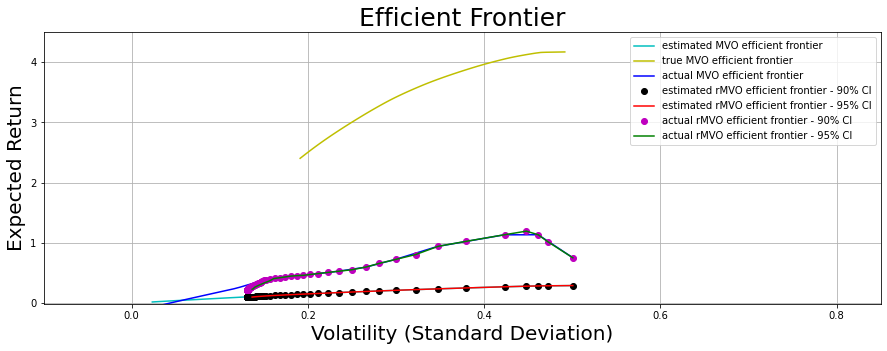

In [43]:
###realized return as true return
ax = plt.gca()
plt.rcParams['figure.figsize'] = [15, 5]
# Plot efficient frontier
ax.plot(np.sqrt(var_eef_list), ret_eef_list, 'c-', label='estimated MVO efficient frontier')
ax.plot(np.sqrt(var_tef_list), ret_tef_list, 'y-',label='true MVO efficient frontier')
ax.plot(np.sqrt(var_aef_list), ret_aef_list, 'b-',label='actual MVO efficient frontier')
ax.plot(np.sqrt(var_eref90_list), ret_eref90_list, 'ko', label='estimated rMVO efficient frontier - 90% CI')
ax.plot(np.sqrt(var_eref95_list), ret_eref95_list, 'r-', label='estimated rMVO efficient frontier - 95% CI')
ax.plot(np.sqrt(var_aref90_list), ret_aref90_list, 'mo', label='actual rMVO efficient frontier - 90% CI')
ax.plot(np.sqrt(var_aref95_list), ret_aref95_list, 'g-', label='actual rMVO efficient frontier - 95% CI')
ax.axis([-0.1,0.85, -0.01, 4.5])
ax.set_xlabel('Volatility (Standard Deviation)', fontsize = 20)
ax.set_ylabel('Expected Return', fontsize = 20)
plt.title('Efficient Frontier', fontsize = 25)
ax.legend(loc="upper right")
ax.grid()
plt.show()